# Word Mover's Distance

> **Note:**
>
> Almost everything in this notebook is subject to change at the moment.

Word Mover's Distance (WMD) is a new and exciting method in machine learning that helps us measure the similarity of two sentences. WMD can be used for document retrieval, and has been shown to outperform many of the current state-of-the-art methods in $k$-nearest neighbors classification [1]. As we shall see, the benefit of WMD is that we can accurately assess the similarity of two documents, even when they have no words in common.

WMD uses word2vec vector embeddings [2] of words (read about word2vec in Gensim [here](http://rare-technologies.com/deep-learning-with-word2vec-and-gensim/) and [here](http://rare-technologies.com/word2vec-tutorial/)).

WMD is illustrated below for two very similar sentences. The sentences have no words in common, but by matching the relevant words, WMD is able to accurately measure the similarity between the two sentences. The method also uses the bag-of-words representation of the documents (simply put, the word's frequencies in the documents), noted as $d$ in the figure below. The intution behind the method is that we find the minimum "traveling distance" between documents, the most efficient way to "move" the distribution of document 1 to the distribution of document 2.

<img src='https://vene.ro/images/wmd-obama.png' height='600' width='600'>


This method was introduced in the article "From Word Embeddings To Document Distances" by Matt Kusner et al. ([link to PDF](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf)). It is inspired by the "Earth Mover's Distance", and employs a solver of the "transportation problem".

In this tutorial, we will learn how to use Gensim's WMD functionality, which consists of the `wmdistance` method for distance computation, and the `WmdSimilarity` class for corpus based similarity queries.

> **Note**:
>
> If you use this software, please consider citing the following papers:
>
> Ofir Pele and Michael Werman, "A linear time histogram metric for improved SIFT matching".
> 
> Ofir Pele and Michael Werman, "Fast and robust earth mover's distances".
>
> Matt Kusner et al. "From Word Embeddings To Document Distances".

> **Running this notebook:**
>
> You can download this [iPython Notebook](http://ipython.org/notebook.html) (**FIXME:** how?), and run it on your own computer, provided you have installed Gensim and NLTK, and downloaded the necessary data.
>
> The notebook was run on an Ubuntu machine with an Intel core i7-4770 CPU 3.40GHz (8 cores) and 32 GB memory. Running the entire notebook on this machine takes about 5 minutes. (**TODO: update this when code is optimized**).

## Using WMD

To use WMD, we need some word embeddings first of all. You could train a word2vec (see tutorial [here](http://rare-technologies.com/word2vec-tutorial/)) model on some corpus, but we will start by download some pre-trained word2vec embeddings. Download these embeddings [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit). Training your own embeddings can be beneficial, but to simplify this tutorial, we will be using pre-trained embeddings at first.

Let's take some sentences to compute the distance between.

In [14]:
from time import time
start_nb = time()

In [15]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

sentence1 = 'Obama speaks to the media in Illinois'
sentence2 = 'The president greets the press in Chicago'
sentence1 = sentence1.lower().split()
sentence2 = sentence2.lower().split()

These sentences have very similar content, and as such the WMD should be low. Before we compute the WMD, we want to remove stopwords ("the", "to", etc.), as these do not contribute a lot to the information in the sentences.

In [16]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')
sentence1 = [w for w in sentence1 if w not in stop_words]
sentence2 = [w for w in sentence2 if w not in stop_words]

[nltk_data] Downloading package stopwords to /home/olavur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, as mentioned earlier, we will be using some downloaded pre-trained embeddings. We load these into a Gensim Word2Vec model class. Note that the embeddings we have chosen here require a lot of memory.

In [17]:
start = time()

from gensim.models import Word2Vec

model = Word2Vec.load_word2vec_format('/data/w2v_googlenews/GoogleNews-vectors-negative300.bin.gz', binary=True)

print 'Cell took %f seconds to run.' %(time() - start)

Cell took 85.303351 seconds to run.


So let's compute WMD using the `wmdistance` method.

In [18]:
distance = model.wmdistance(sentence1, sentence2)
print 'distance = %.4f' % distance

distance = 1.0175


Let's try the same thing with two completely unrelated sentences. Notice that the distance is larger.

In [19]:
sentence1 = 'Obama speaks to the media in Illinois'
sentence3 = 'Oranges are my favorite type of fruit'
sentence1 = sentence1.lower().split()
sentence3 = sentence3.lower().split()
sentence1 = [w for w in sentence1 if w not in stop_words]
sentence3 = [w for w in sentence3 if w not in stop_words]

distance = model.wmdistance(sentence1, sentence3)
print 'distance = %.4f' % distance

distance = 1.3604


### Normalizing word2vec vectors

When using the `wmdistance` method, it is beneficial to normalize the word2vec vectors first, so they all have length equal to 1. To do this, simply call `model.init_sims(replace=True)` and Gensim will take care of that for you.

The reason it is beneficial to use normalized vectors is that word2vec is optimized for cosine distance (see [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)), which measures the angle between vectors, but WMD uses Euclidean distance. The Euclidean distance between two vectors might be large because their lengths differ, but the cosine distance is small because the angle between them is small; we can mitigate some of this by normalizing the vectors.

Note that normalizing the vectors can take some time, especially if you have a large vocabulary and/or large vectors.

Usage is illustrated in the example below. It just so happens that the vectors we have downloaded are already normalized, so it won't do any difference in this case.

In [20]:
# Normalizing word2vec vectors.
start = time()

model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

distance = model.wmdistance(sentence1, sentence2)  # Compute WMD as normal.

print 'Cell took %f seconds to run.' %(time() - start)

Cell took 12.009372 seconds to run.


### Pre-computing distance matrix

If you are computing distances between a lot of documents (as we will be doing in the next section), we can speed up the process by pre-computing the distances between all the words in the vocabulary.

**FIXME:** finish this section when pre-computing distance matrix is implented.

## Similarity queries

You can use WMD to get the most similar documents to a query, using the `WmdSimilarity` class. Its interface is similar to what is described in the [Similarity Queries](https://radimrehurek.com/gensim/tut3.html) Gensim tutorial.

> **Important note:**
>
> WMD is a measure of *distance*, which is in fact the opposite of similarity. The similarities in `WmdSimilarity` are simply the *negative distance*. Be careful not to confuse distances and similarities.

Let's try similarity queries using some real world data. For that we'll be using Yelp reviews, available at http://www.yelp.com/dataset_challenge. Specifically, we will be using reviews of a single restaurant.

This time around, we are going to train the Word2Vec embeddings on the data ourselves. One restaurant is not enough to train Word2Vec properly, so we use 6 restaurants for that, but only run queries against one of them. More information about the data is in the **Yelp data** section.

Below a JSON file with Yelp reviews is read line by line, the text is extracted, tokenized, and stopwords and punctuation are removed.

In [21]:
start = time()

import json
from nltk import word_tokenize
download('punkt')  # Download data for tokenizer.

# Business IDs of some restaurants.
ids = ['4bEjOyTaDG24SY5TxsaUNQ', '2e2e7WgqU1BnpxmQL5jbfw', 'zt1TpTuJ6y9n551sw9TaEg',
      'Xhg93cMdemu5pAMkDoEdtQ', 'sIyHTizqAiGu12XMLX3N3g', 'YNQgak-ZLtYJQxlDwN-qIg']

# Load some text data.
w2v_corpus = []  # Documents to train word2vec on.
wmd_corpus = []  # Documents to run queries against.
documents = []  # wmd_corpus, with no pre-processing (so we can print the original documents).
with open('/home/olavur/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json') as data_file:
    for line in data_file:
        json_line = json.loads(line)
        
        if json_line['business_id'] not in ids:
            # Not interested in this business.
            continue
        
        # Pre-process document.
        text = json_line['text'].lower()  # Lower the text.
        text = word_tokenize(text)  # Split into words.
        text = [w for w in text if not w in stop_words]  # Remove stopwords.
        text = [w for w in text if w.isalpha()]  # Remove numbers and punctuation.
        
        # Add to corpus for training Word2Vec.
        w2v_corpus.append(text)
        
        if json_line['business_id'] == ids[0]:
            # Only use this restaurant in corpus for WmdSimilarity.
            wmd_corpus.append(text)
            documents.append(json_line['text'])

print '\nCell took %f seconds to run.' %(time() - start)

[nltk_data] Downloading package punkt to /home/olavur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Cell took 40.473196 seconds to run.


In [22]:
# Train Word2Vec on all the restaurants.
model = Word2Vec(w2v_corpus, workers=7, size=100)

Now we want to initialize the similarity class with a corpus and a word2vec model (which provides the embeddings and the `wmdistance` method itself).

In [23]:
from gensim.similarities import WmdSimilarity
instance = WmdSimilarity(wmd_corpus, model, num_best=10)

The `num_best` parameter decides how many results the queries return. Now let's try making a query. The output is a list of indeces and similarities of documents in the corpus, sorted by similarity. Note that the output format is slightly different when `num_best` is `None` (i.e. not assigned).

The query below is taken directly from one of the reviews in the corpus. Let's see if there are other reviews that are similar to this one.

In [24]:
start = time()

sent = 'Very good, you should seat outdoor.'

# Pre-process query.
query = sent.lower()  # Lower the text.
query = word_tokenize(query)  # Split into words.
query = [w for w in query if not w in stop_words]  # Remove stopwords.
query = [w for w in query if w.isalpha()]  # Remove numbers and punctuation.

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print 'Cell took %f seconds to run.' %(time() - start)

Cell took 5.643348 seconds to run.


The query and the most similar documents, together with the similarities, are printed below. We see that the retrieved documents are discussing the same thing as the query, although using different words. The query talks about getting a seat "outdoor", while the results talk about sitting "outside", and one of them says the restaurant has a "nice view".

**FIXME:** last result doesn't mention "nice view" anymore.

In [25]:
# Print the query and the retrieved documents, together with their similarities.
print 'Query:'
print sent
for i in range(3):
    print
    print 'sim = %.4f' % sims[i][1]
    print documents[sims[i][0]]

Query:
Very good, you should seat outdoor.

sim = -0.7420
It's a great place if you can sit outside in good weather.

sim = -0.7433
It was good I like the outside

sim = -0.8531
Best seat in the house with view of water fountain, good wine, good food n good service.


Let's try a different query.

In [26]:
start = time()

sent = 'I felt that the prices were extremely reasonable for the Strip'

# Pre-process query.
query = sent.lower()  # Lower the text.
query = word_tokenize(query)  # Split into words.
query = [w for w in query if not w in stop_words]  # Remove stopwords.
query = [w for w in query if w.isalpha()]  # Remove numbers and punctuation.

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print 'Query:'
print sent
for i in range(3):
    print
    print 'sim = %.4f' % sims[i][1]
    print documents[sims[i][0]]
    
print '\nCell took %f seconds to run.' %(time() - start)

Query:
I felt that the prices were extremely reasonable for the Strip

sim = -0.7226
Reasonable prices. Makes for a nice dinner out in the town.

sim = -0.8358
Exceptional food at reasonable prices.  Reservations are a must.

sim = -0.8684
Incredible restaurant on the strip! Very reasonable prices, outstanding service, an breathtaking views. Bar none, my favorite meal on the Strip.

Cell took 7.948464 seconds to run.


This time around, the results are more straight forward; the retrieved documents basically contain the same words as the query.

### Yelp data

As mentioned previously, we used reviews of 6 different restaurants to train Word2Vec, and then ran queries against one of these restaurants. The restaurants we chose were those with the highest number of reviews in the Yelp dataset.

The corpus we trained Word2Vec on has 18957 documents (reviews), and the corpus we used for `WmdSimilarity` has 4137 documents.

Below is a plot with a histogram of document lengths and includes the average document length as well. Note that these are the pre-processed documents, meaning stopwords are removed, punctuation is removed, etc.

/home/olavur/WMD/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


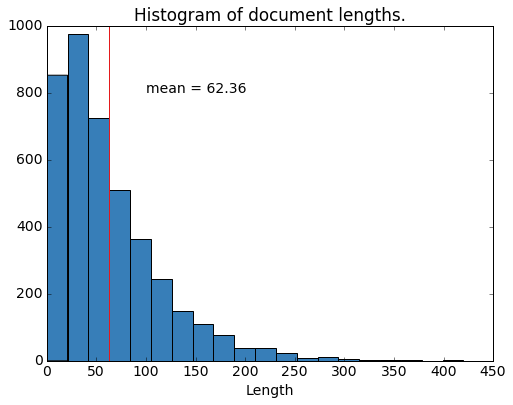

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

# Document lengths.
lens = [len(doc) for doc in wmd_corpus]

# Plot.
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))
# Histogram.
plt.hist(lens, bins=20)
plt.hold(True)
# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.hold(False)
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.text(100, 800, 'mean = %.2f' % avg_len)
plt.show()

## References

1. Matt Kusner et al. *From Embeddings To Document Distances*, 2015.
* Thomas Mikolov et al. *Efficient Estimation of Word Representations in Vector Space*, 2013.

In [28]:
print 'Notebook took %f seconds to run.' %(time() - start_nb)

Notebook took 156.993049 seconds to run.
